In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap

import networkx as nx

from minimal.imaging import blit_rooms
from minimal.layout import LayoutGraph, NodeType
from minimal.gen import generate_plan, PlanMasks
from minimal import sample_graphs
from minimal.correction import RoomAreas
from minimal.walls import intersect_rooms, detect_unjoined_corners

%matplotlib inline

In [3]:
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_02.pth"))

In [4]:
%%time

min_area_units = 10
rooms = []
for i, node in enumerate(pm.graph.nodes):
    if not NodeType.is_room(node):
        continue

    room = RoomAreas(node, pm.masks[i])
    room.threshold_rectangles(min_area_units)
    room.discard_small_components()
    rooms.append(room)

CPU times: user 1.05 s, sys: 756 µs, total: 1.05 s
Wall time: 1.05 s


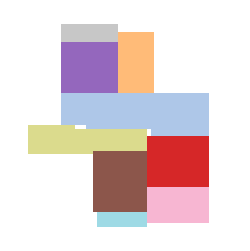

In [5]:
room_index_mask = sum(room.to_mask() * (i + 1) for i, room in enumerate(rooms))
room_index_mask.shape

plt.figure(figsize=(3,3))
cmap = ListedColormap(['white', *plt.get_cmap('tab20').colors])
plt.axis("off")
plt.imshow(room_index_mask, cmap=cmap)

In [6]:
inner_mask, inner_walls, outer_mask, outer_walls = intersect_rooms(rooms)
all_walls = (inner_walls + outer_walls).clamp_max_(1)

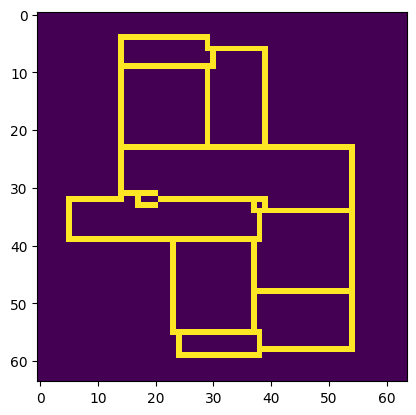

In [16]:
from minimal.walls import detect_unjoined_corners
corners = detect_unjoined_corners(all_walls, inner_mask)
filled_walls_1 = all_walls + corners

plt.imshow(filled_walls_1)

# plt.figure(figsize=(15,5))

# plt.subplot(1,3,1)
# plt.imshow(all_walls + m)

# plt.subplot(1,3,2)
# plt.imshow(p_walls.squeeze())

# plt.subplot(1,3,3)
# plt.imshow(all_walls + m + p_walls.squeeze())